## Read in peripheral study recording

In [1]:
# given a filename, generate a pandas dataframe with all recording stuff

# L, R, combined fields

In [3]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording
from pathlib import Path
from tqdm import tqdm

In [4]:
%matplotlib ipympl

In [5]:
%load_ext autoreload
%autoreload 2

## Load data (txt or pkl)

In [6]:
path_to_recording = "C:\\EGLC\\\carla\\PythonAPI\\examples\\recordings\\sud32.txt"
path_to_recording = "data/george-55.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

try:
    df1 = pd.read_pickle(recdf_pklname)
except FileNotFoundError:
    df1 = read_periph_recording(path_to_recording)
    df1.to_pickle(recdf_pklname)
df1 = df1.convert_dtypes()

16468it [00:38, 432.01it/s]


## Data Playground and Sanity checks

In [7]:
gazeRaySplitDF = pd.DataFrame(df1["GazeRay"].to_list(), columns=['gaze_x', 'gaze_y', 'gaze_z'], index=df1.index)
# print(gazeRaySplitDF)
df2 = df1.join(gazeRaySplitDF)
gaze_pitches = np.arctan2(df2.gaze_z, df2.gaze_x)*180/np.pi
gaze_yaws = np.arctan2(df2.gaze_y, df2.gaze_x)*180/np.pi

low_conf_gazeidcs = (gaze_pitches*gaze_yaws == 0)
gaze_pitches = gaze_pitches[~low_conf_gazeidcs]
gaze_yaws = gaze_yaws[~low_conf_gazeidcs]


print(np.min(gaze_pitches),np.max(gaze_pitches))
print(np.min(gaze_yaws),np.max(gaze_yaws))

-38.52536177139017 5.4431253947339835
-23.684867582773226 27.25985462211186


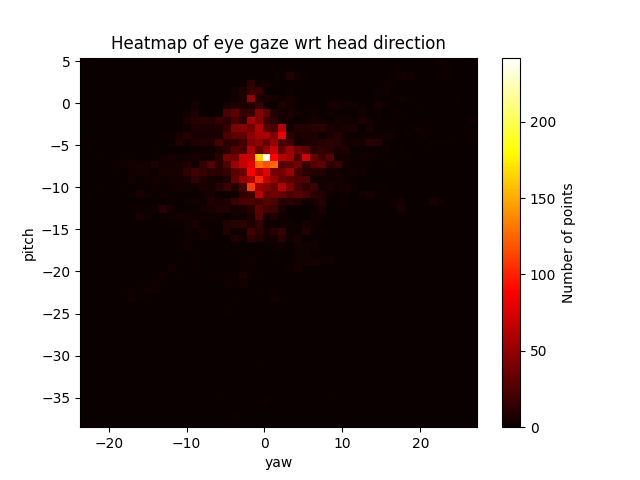

In [8]:
#gaze_pitches = gaze_pitches[1000:7000]
#gaze_yaws = gaze_yaws[6000:7000]

# Generate heat map of eye gaze wrt head pos
plt.figure()
plt.hist2d(gaze_yaws, gaze_pitches,
           bins=50, cmap='hot')
cb = plt.colorbar()
cb.set_label('Number of points')
plt.title('Heatmap of eye gaze wrt head direction')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.show()

In [9]:
# find the indices where lights came on and went off
lighton_rows = df1["LightOn"].diff().fillna(0)==1
lightoff_rows = df1["LightOn"].diff().fillna(0)==-1
df1[lighton_rows].head()
lighton_idcs = df1[lighton_rows].index
# df1[lightoff_idcs].head()
num_targets_spawned = sum(lighton_rows)

In [10]:
# find the indices where the button was pressed
buttonPress_rows = df1["ButtonPressed"].diff().fillna(0)==1
buttonRelease_rows = df1["ButtonPressed"].diff().fillna(0)==-1
# df1[buttonPress_idcs]

In [11]:
# average target appearance time
df1[buttonRelease_rows].TimeElapsed.reset_index()  - df1[buttonPress_rows].TimeElapsed.reset_index()

,FrameNum,TimeElapsed
0,7,0.1545
1,8,0.1777
2,5,0.1123
3,7,0.1562
4,8,0.1791
5,7,0.155
6,8,0.173
7,7,0.158
8,8,0.177
9,10,0.222


In [12]:
num_button_presses = sum(buttonPress_rows)
print("{} targets spawned".format(num_targets_spawned))
print("{} responses recorded".format(num_button_presses)) # may or may not be all accurate responses that correspond to targets?

18 targets spawned
13 responses recorded


In [13]:
colBP = df1["ButtonPressed"].astype(int)

In [14]:
df1.columns

Index(['gaze2target_pitch', 'gaze2target_yaw', 'head2target_pitch',
       'head2target_yaw', 'LightOn', 'ButtonPressed', 'WorldPos', 'WorldRot',
       'AbsoluteEyeOrigin', 'T_SRanipal', 'T_Carla', 'FrameSeq', 'GazeRay',
       'RelativeEyeOrigin', 'Vergence', 'HMDLoc', 'HMDRot', 'EgoVel',
       'LGazeRay', 'LEyeOrigin', 'RGazeRay', 'REyeOrigin', 'LEyeOpenness',
       'REyeOpenness', 'LPupilPos', 'RPupilPos', 'LPupilDiam', 'RPupilDiam',
       'FActorName', 'FActorPoint', 'FActorDist', 'GazeV', 'LGazeV', 'RGazeV',
       'LEyeOpenV', 'REyeOpenV', 'LPupilPosV', 'RPupilPosV', 'Throttle',
       'Steering', 'Brake', 'ToggleRev', 'TurnSignalLeft', 'TurnSignalRight',
       'Handbrake', 'TimeElapsed'],
      dtype='object')

## Hits and Misses calculation

In [15]:
# for every light appearance
# find the nearest button press, before the next target appearance
max_reaction_time_allowed = 5 #seconds
time_offsets = []
hits_and_misses = []
for idx_num, lighton_idx in tqdm(enumerate(lighton_idcs)):
    # while not found_buttonpress or lighton_idcs[idx_num+1]:
    offset = 0
    target_tuple = (df1.loc[lighton_idx], False)
    while lighton_idx+offset < max(df1.index):
        time_offset = df1.loc[lighton_idx+offset, "TimeElapsed"] - df1.loc[lighton_idx, "TimeElapsed"]   
        if (df1.loc[lighton_idx+offset, "ButtonPressed"] == 1):
            # print("{0:1.2f}s".format(time_offset))
            time_offsets += [time_offset]
            target_tuple = (df1.loc[lighton_idx], df1.loc[lighton_idx+offset])
            break
        else:
            if time_offset > max_reaction_time_allowed:
                break
            offset += 1
    hits_and_misses += [target_tuple]
print("{}/{} hits with a {}s average reaction time".format(len(time_offsets), len(lighton_idcs), sum(time_offsets)/len(time_offsets)))

18it [00:00, 22.36it/s]

13/18 hits with a 0.691s average reaction time


(0.0, 2.0)

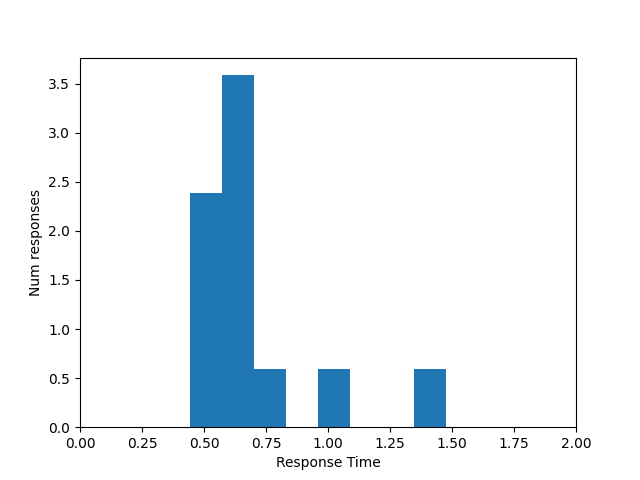

In [17]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(time_offsets, bins=8, density=True)
ax.set_xlabel('Response Time')
ax.set_ylabel('Num responses')
ax.set_xlim(0, 2)
# ax.set_title(r'sigma=15$')

In [ ]:
# TODO find buttonpress false positives -- might have to iterate over button presses

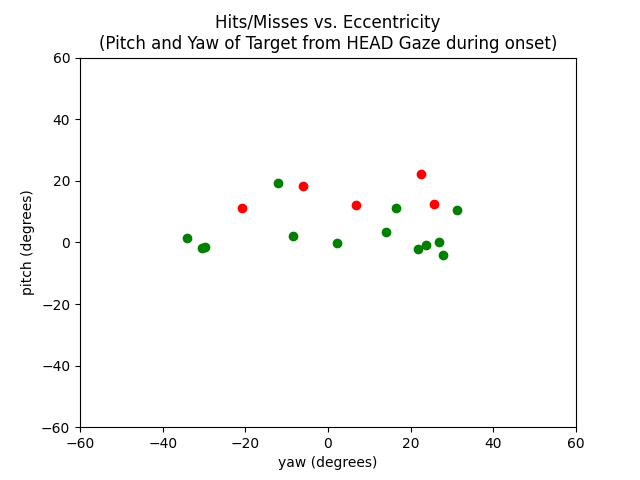

In [18]:
# Preliminary analysis
fig, ax = plt.subplots()

# plots of hits misses vs ecc
for target_tuple in hits_and_misses:
    target_response = True
    if target_tuple[1] is False:
        # miss
        target_response = False
        pass
    else:
        # hits
        pass
        # print(target_tuple[1].ButtonPressed)
    # ax.scatter(target_tuple[0].gaze2target_yaw*180/np.pi, target_tuple[0].gaze2target_pitch*180/np.pi, c='g' if target_response else 'r')
    # ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from EYE Gaze during onset)")
    
    ax.scatter(target_tuple[0].head2target_yaw*180/np.pi, target_tuple[0].head2target_pitch*180/np.pi, c='g' if target_response else 'r')
    ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from HEAD Gaze during onset)")
    
    ax.set_xlabel("yaw (degrees)")
    ax.set_ylabel("pitch (degrees)")
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    # ax.show()
    

## Gaze event detection and OFD based analysis

In [19]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline

In [79]:
LgazeRaySplitDF = pd.DataFrame(np.array(df1["LGazeRay"].to_list()), columns=['x', 'y', 'z'], index=df1.index)#.convert_dtypes()
LgazeRaySplitDF['timestamp'] = df1["TimeElapsed"]
LgazeRaySplitDF['confidence'] = df1["LEyeOpenV"].astype(int) # remove all gazes where an eye was closed

RgazeRaySplitDF = pd.DataFrame(np.array(df1["RGazeRay"].to_list()), columns=['x', 'y', 'z'], index=df1.index)#.convert_dtypes()
RgazeRaySplitDF['timestamp'] = df1["TimeElapsed"]
RgazeRaySplitDF['confidence'] = df1["REyeOpenV"].astype(int) # remove all gazes where an eye was closed

In [90]:
pdGaze = pd.DataFrame(gazeRaySplitDF, columns = ['x','y','z']) #.convert_dtypes()
pdGaze['timestamp'] = df1["TimeElapsed"]
pdGaze['confidence'] = (df1["LEyeOpenV"]*df1["REyeOpenV"]).astype(int)

velL = EyeClassifier.preprocess(LgazeRaySplitDF)
velL.velocity = velL.velocity.astype(float)
velR = EyeClassifier.preprocess(RgazeRaySplitDF)
velR.velocity = velR.velocity.astype(float)

In [89]:
model = EyeClassifier()
model.fit(eyes=(velL, velR))

In [92]:
labels, indiv_labels = model.predict(eyes=(velL, velR))
print(labels)
labels_np = labels.to_numpy()
labels_np = labels_np[1::2] # remove duplicates
print("labels_np.shape: ", labels_np.shape)

       timestamp  label  count_fix  count_sac  count_nse
id                                                      
0            0.0     -1          0          0          1
1            0.0     -1          0          0          1
2       0.021741      0          1          0          0
3       0.021741      0          1          0          0
4       0.044295      0          1          0          0
...          ...    ...        ...        ...        ...
16463    185.317     -1          0          0          1
16464    185.339     -1          0          0          1
16465    185.339     -1          0          0          1
16466    185.361     -1          0          0          1
16467    185.361     -1          0          0          1

[16468 rows x 5 columns]
labels_np.shape:  (8234, 5)
